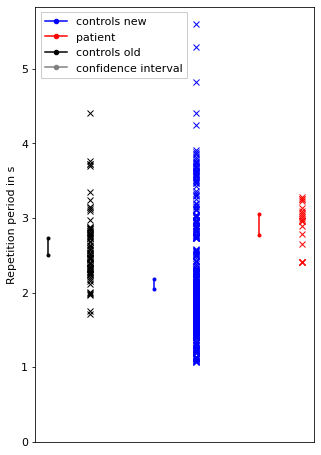

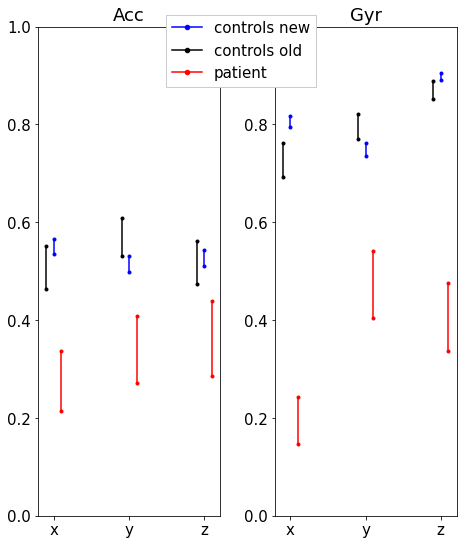

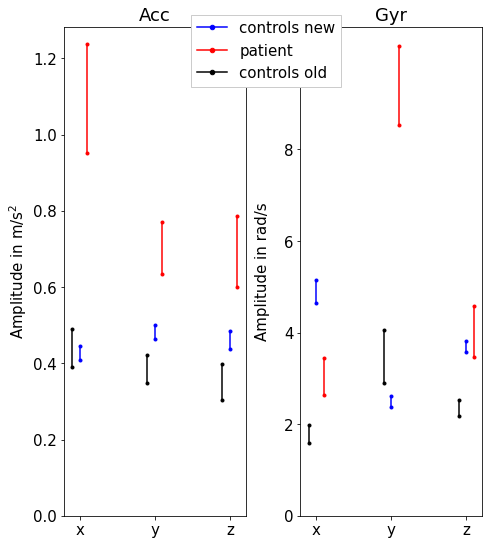

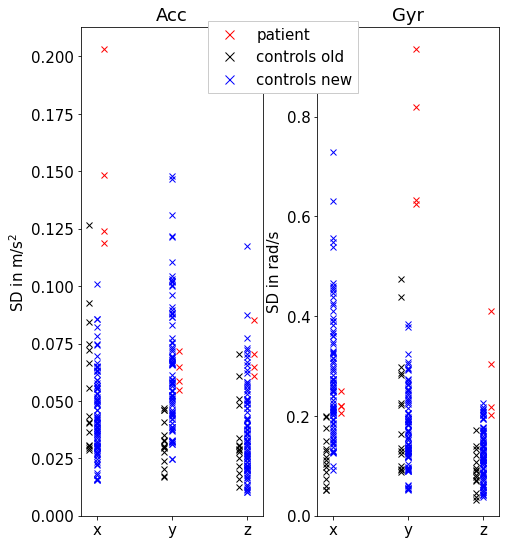

In [11]:
from logging import handlers
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import scipy.stats as st
import re


def load_data(file):
    data = {}
    with open('Results\\' + file, 'r') as f:
        for line in f.readlines():
            lines = line.split('\t')
            curr_data = data
            for i in range(0, len(lines) - 1):
                if i != len(lines) - 2:
                    if not lines[i] in curr_data:
                        curr_data[lines[i]] = {}
                    curr_data = curr_data[lines[i]]
                else:
                    if not lines[i] in curr_data:
                        curr_data[lines[i]] = []
            curr_data[lines[len(lines) - 2]] = np.concatenate([np.array(curr_data[lines[len(lines) - 2]]), 
                                                                      (re.sub('\D$', '', re.sub('^\D', '', lines[len(lines) - 1]))).split(',')]).astype(float)
    return data
    
def get_confidence_intervals_period(data, bool_multi):
    cf_data = {}
    for subject in data:
        if subject in controls_old:
            participant_group = 'controls old'
        elif subject in controls_new:
            participant_group = 'controls new'
        elif subject in patients:
            participant_group = 'patient'
        else:
            continue
        for task in data[subject]:
            if not participant_group in cf_data:
                cf_data[participant_group] = []
            for datapoint in data[subject][task]:
                cf_data[participant_group].append(datapoint)                                                               
    confidence_intervals = {}
    for participant_group in cf_data:
        
        cintervals_patient = st.t.interval(alpha=0.95, 
                                            df=len(cf_data[participant_group])-1, 
                                            loc=np.mean(cf_data[participant_group]), 
                                            scale=st.sem(cf_data[participant_group]))  
        confidence_intervals[participant_group] = cintervals_patient

    return confidence_intervals

def get_confidence_intervals(data, bool_multi):
    cf_data = {}
    for subject in data:
        if subject in controls_old:
            participant_group = 'controls old'
        elif subject in controls_new:
            participant_group = 'controls new'
        elif subject in patients:
            participant_group = 'patient'
        else:
            continue
        for task in data[subject]:
             for sensor in data[subject][task]:
                    if not(participant_group == 'controls new') or  sensor == '000_00B4496D':
                        for signal_type in data[subject][task][sensor]:
                            if signal_type in ['Acc', 'Gyr']:
                                for axis in data[subject][task][sensor][signal_type]:
                                    for datapoint in data[subject][task][sensor][signal_type][axis]:
                                        curr_data = datapoint
                                        if not participant_group in cf_data:
                                            cf_data[participant_group] = {}
                                        if not signal_type in cf_data[participant_group]:
                                            cf_data[participant_group][signal_type] = {}
                                        if not axis in cf_data[participant_group][signal_type]:
                                            cf_data[participant_group][signal_type][axis] = []
                                        cf_data[participant_group][signal_type][axis].append(curr_data)                                                               

    confidence_intervals = {}
    for participant_group in cf_data:
        for signal_type in cf_data[participant_group]:
            for axis in cf_data[participant_group][signal_type]:
                curr_data = cf_data[participant_group][signal_type][axis]
                cintervals_patient = st.t.interval(alpha=0.95, 
                                                    df=len(curr_data)-1, 
                                                    loc=np.mean(curr_data), 
                                                    scale=st.sem(curr_data)) 
                if not participant_group in confidence_intervals:
                    confidence_intervals[participant_group] = {}
                if not signal_type in confidence_intervals[participant_group]:
                    confidence_intervals[participant_group][signal_type] = {}
                confidence_intervals[participant_group][signal_type][axis] = cintervals_patient

    return confidence_intervals


def plot_confidence_intervals_signal_period(cf_data, data, bool_multi, subject):
    
    legend_elements = []
    fig = plt.figure(figsize = (5,8))
    for participant_group in cf_data:
        if participant_group == 'controls old':
            color = 'black'
            o = -0.05
        elif participant_group == 'controls new':
            color = 'blue'
            o = 0
        elif participant_group == 'patient':
            color = 'red'
            o = 0.05
        
        if participant_group == 'patient':
            if subject == 'MR':
                legend_elements.append(Line2D([0], [0],  marker='.', linestyle='-', color=color, label=participant_group))
            else:
                legend_elements.append(Line2D([0], [0],  marker='.', linestyle='-', color=color, label=subject))
        else:     
            legend_elements.append(Line2D([0], [0],  marker='.', linestyle='-', color=color, label=participant_group))
        plt.plot((o,o), cf_data[participant_group], '-', marker='.', color = color)
    for subject in data:
        if subject in controls_old:
            participant_group = 'controls old'
            color = 'black'
            o = -0.03
        elif subject in controls_new:
            participant_group = 'controls new'
            color = 'blue'
            o = 0.02
        elif subject in patients:
            participant_group = 'patient'
            color = 'red'
            o = 0.07
        for task in data[subject]:
            for elem in data[subject][task]:
                plt.plot(o, elem,  marker='x', color = color)         
    plt.xticks([])
       
    legend_elements.append(Line2D([0], [0],  marker='.', linestyle='-', color='grey', label='confidence interval'))
    plt.ylabel('Repetition period in s')
    plt.ylim(bottom=0)
    plt.legend(handles=legend_elements, markerscale = 1.5,
               loc = 'upper left',bbox_to_anchor=(0, 1),borderaxespad = 0.5, fancybox = False, framealpha = 1)
    return fig

def plot_high_freq(data, ylabels, bool_multi):
    legend_elements = []
    fig, ax = plt.subplots(ncols=2, figsize = (7.5,9))
    plt.subplots_adjust(wspace=0.3)
    for subject in data:
        i = 0
        if subject in controls_old:
            participant_group = 'controls old'
            color = 'black'
            o = -0.02
        elif subject in controls_new:
            participant_group = 'controls new'
            color = 'blue'
            o = 0
        elif subject in patients:
            participant_group = 'patient'
            color = 'red'
            o = 0.02
            if subject != 'MR':
                legend_elements.append(Line2D([0], [0],  marker='x', linestyle='None', color='red', label=subject))    
            else:
                legend_elements.append(Line2D([0], [0],  marker='x', linestyle='None', color='red', label='patient'))    
        else:
            continue
        for task in data[subject]:
            for sensor in data[subject][task]:
                if not(participant_group == 'controls new') or  sensor == '000_00B4496D':
                    i = 0
                    for signal_type in data[subject][task][sensor]:
                        if signal_type in ['Acc', 'Gyr']:
                            for axis in data[subject][task][sensor][signal_type]:
                                for datapoint in data[subject][task][sensor][signal_type][axis]:
                                    if axis[len(axis) - 2:] == 'X':
                                        offset = -0.2
                                    elif axis[len(axis) - 2:] == 'Y':
                                        offset = 0
                                    elif axis[len(axis) - 2:] == 'Z':
                                        offset = 0.2
                                    ax[i].plot(o + offset, datapoint , marker='x', color = color)
                                ax[i].set_xticks([o + -0.2,o +  0, o + 0.2], labels = ['x', 'y', 'z'])
                                ax[i].set_title(signal_type)
                            ax[i].set_ylabel(ylabels[i])
                            i += 1
    legend_elements.append(Line2D([0], [0],  marker='x', linestyle='None', color='black', label='controls old'))    
    legend_elements.append(Line2D([0], [0],  marker='x', linestyle='None', color='blue', label='controls new'))    

    for i in range(0, 2):
        if type == 'correlation':
                ax[i].set_ylim([0,1])
        else:
            ax[i].set_ylim(bottom=0) 
    
    fig.legend(handles=legend_elements,  markerscale = 1.5, loc = 'upper center',bbox_to_anchor=(0.5, 0.9)
            ,borderaxespad = 0.5, fancybox = False, framealpha = 1)
    
    return fig
    

def plot_confidence_intervals(data, num, ylabels, type, bool_multi, subject):
    
    legend_elements = []
    fig, ax = plt.subplots(ncols=num, figsize = (7.5,9))
    plt.subplots_adjust(wspace=0.3)
    for participant_group in data:
        i = 0
        if participant_group == 'controls old':
            color = 'black'
            o = -0.02
        elif participant_group == 'controls new':
            color = 'blue'
            o = 0
        elif participant_group == 'patient':
            color = 'red'
            o = 0.02
        if participant_group == 'patient':
            if subject == 'MR':
                legend_elements.append(Line2D([0], [0],  marker='.', linestyle='-', color=color, label=participant_group))
            else:
                legend_elements.append(Line2D([0], [0],  marker='.', linestyle='-', color=color, label=subject))
        else:     
            legend_elements.append(Line2D([0], [0],  marker='.', linestyle='-', color=color, label=participant_group))
        for signal_type in data[participant_group]:
            for axis in data[participant_group][signal_type]:
                
                if axis[len(axis) - 2:] == 'X':
                    offset = -0.2
                elif axis[len(axis) - 2:] == 'Y':
                    offset = 0
                elif axis[len(axis) - 2:] == 'Z':
                    offset = 0.2
                ax[i].plot((offset + o, offset + o), data[participant_group][signal_type][axis] ,'-', marker='.', color = color)
            ax[i].set_xticks([-0.2, 0, 0.2], labels = ['x', 'y', 'z'])
            ax[i].set_title(signal_type)
            ax[i].set_ylabel(ylabels[i])
            
            i += 1
    for i in range(0, num):
        if type == 'correlation':
                ax[i].set_ylim([0,1])
        else:
            ax[i].set_ylim(bottom=0)    

    fig.legend(handles=legend_elements,  markerscale = 1.5,loc = 'upper center',bbox_to_anchor=(0.5, 0.91)
            ,borderaxespad = 0.5, fancybox = False, framealpha = 1)           
    return fig

controls_old_orig = ['QR', 'RR', 'SR','VR', 'UR']
controls_new_orig = ['A', 'B', 'C', 'D', 'E', 'F', 'GR', 'H', 'I', 'J', 'K']
patients_orig = ['MR']

subject_list = np.concatenate([controls_old_orig, controls_new_orig, patients_orig])

for subject in subject_list:
    patients = [subject]
    controls_new = controls_new_orig.copy()
    if subject in controls_new:
        controls_new.remove(subject)
    controls_old = controls_old_orig.copy()
    if subject in controls_old:
        controls_old.remove(subject)
    high_freqs = load_data('pointing_repetition_high_freq.csv')
    amplitudes = load_data('pointing_repetition_amplitude.csv')
    correlation = load_data('pointing_repetition_correlation.csv')
    period = load_data('pointing_repetition_period.csv')
    cf_correlation = get_confidence_intervals(correlation, True)
    cf_period = get_confidence_intervals_period(period, True)
    cf_amplitudes = get_confidence_intervals(amplitudes, True)
    plt.rcParams.update({'font.size': 11})
    fig_period = plot_confidence_intervals_signal_period(cf_period, period, True, patients[0])
    plt.rcParams.update({'font.size': 15})
    fig_correlation = plot_confidence_intervals(cf_correlation, 2, ['', ''], 'correlation', True, patients[0])
    fig_amplitude = plot_confidence_intervals(cf_amplitudes,2, ['Amplitude in m/s$^2$', 'Amplitude in rad/s'], 'amplitude', True, patients[0])
    fig_high_freq = plot_high_freq(high_freqs, ['SD in m/s$^2$', 'SD in rad/s'], True)
    
    if subject == 'MR':
        plt.show(fig_correlation)
        fig_period.savefig(('plots\\repetition_period.png'), bbox_inches='tight')
        fig_correlation.savefig(('plots\\repetition_correlation.png'), bbox_inches='tight')
        fig_amplitude.savefig(('plots\\repetition_amplitude.png'), bbox_inches='tight')
        fig_high_freq.savefig(('plots\\repetition_high_freq.png'), bbox_inches='tight')    
    else:
        fig_period.savefig(('plots\\comparison plots\\' + patients[0] + '_period.png'), bbox_inches='tight')
        fig_correlation.savefig(('plots\\comparison plots\\' + patients[0] + '_correlation.png'), bbox_inches='tight')
        fig_amplitude.savefig(('plots\\comparison plots\\' + patients[0] + '_amplitude.png'), bbox_inches='tight')
        fig_high_freq.savefig(('plots\\comparison plots\\' + patients[0] + '_high_freq.png'), bbox_inches='tight')
    
    plt.close(fig_period)
    plt.close(fig_correlation)
    plt.close(fig_amplitude)
    plt.close(fig_high_freq)
